# Analisando Ações do ETF BOVA11
#### Feito por Gabriel Tardochi Salles
## Perguntas:
- Como sao representados os setores nessas ações ?
- Como crescem os setores ?
- Dentro das ações do mesmo setor, como elas se comportam ? 

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from datetime import timedelta
from alpha_vantage.timeseries import TimeSeries
from sklearn.model_selection import train_test_split
import time
%matplotlib inline
plt.style.use('fivethirtyeight')

Puxando quais sao as ações de https://www.blackrock.com/br/products/251816/ishares-ibovespa-fundo-de-ndice-fund..

In [2]:
bova_file = 'BOVA11.xlsx'
bova_stocks = pd.read_excel(bova_file)
bova_stocks.Codigo = bova_stocks.Codigo + '.SA'
bova_stocks.sample(3)

,Codigo,Nome,Peso (%),Preco,Cotas,Valor de mercado,Valor de face,Setor,SEDOL,Codigo ISIN,Bolsa,Localizacao,Moeda,Taxa de cambio
65,USIM5.SA,USINAS SIDERURGICAS DE MINAS GERAI,0.29,10.12,3217842,32564561,32564561.04,Materiais,2386009,BRUSIMACNPA6,XBSP,Brasil,BRL,1
70,EZTC3.SA,EZ TEC EMPREENDIMENTOS E PARTICIPA,0.20,37.71,599726,22615667,22615667.46,Consumo discricionario,B1YW5V4,BREZTCACNOR0,XBSP,Brasil,BRL,1
44,BRAP4.SA,BRADESPAR PREF SA,0.57,46.03,1390884,64022391,64022390.52,Materiais,B01SCS4,BRBRAPACNPR2,XBSP,Brasil,BRL,1


Consultando Yahoo Finance para dados históricos dessas ações, usando Alpha Vantage para preencher dados faltantes

In [3]:
update_data = False
update_alltime_av_data = False

In [4]:
file_name_yf = 'YF_BOVA_FullData.csv'
starting_date = '2020-05-01'
tickers_list = bova_stocks.Codigo.to_list()

# Atualiza os dados se desejado, caso contrario segue com os ja baixados
if update_data:
    yf_data = yf.download(tickers_list, starting_date)['Close'].reset_index(drop=False)
    yf_data = pd.melt(yf_data, id_vars=['Date'], var_name=['Stock'], value_name='close_price').sort_values(by='Date')
    yf_data.to_csv(file_name_yf, index=False)
    
yf_data = pd.read_csv(file_name_yf)
yf_data.sample(3)

,Date,Stock,close_price
7290,2020-09-15,SUZB3.SA,48.889999
4130,2020-07-17,ITSA4.SA,10.270000
1444,2020-05-28,RAIL3.SA,23.170000


In [5]:
file_name_av = 'AV_BOVA_FullData.csv'

# Atualiza os dados se desejado, caso contrario segue com os ja baixados
if update_alltime_av_data:
    with open('alpha_vantage_key.txt') as f:
        ALPHA_VANTAGE_KEY = f.readline()
        f.close()
    ts = TimeSeries(key=ALPHA_VANTAGE_KEY, output_format='pandas')
    for i in range(len(tickers_list)):
        time.sleep(13)
        this_ticker = tickers_list[i] + 'O'
        av_data, meta = ts.get_daily(this_ticker, outputsize='full')
        av_data['stck'] = tickers_list[i]
        av_data = av_data.loc[:, ['4. close', 'stck']]
        av_data.reset_index(drop=False, inplace=True)
        if i == 0:
            av_total_data = av_data
        else:
            av_total_data = av_total_data.append(av_data, ignore_index = True)
        av_total_data.to_csv(file_name_av, index=False)
        
av_total_data = pd.read_csv(file_name_av)
av_total_data.sample(3)

,date,4. close,stck
17127,2010-10-26,36.90,BBDC4.SA
34665,2017-07-12,28.84,BBAS3.SA
112418,2018-07-31,9.18,CSNA3.SA


In [6]:
file_name_price_hist = 'PriceHist_BOVA.csv'
if update_data:
    for i,row in yf_data.iterrows():
        if np.isnan(row['close_price']):
            try:
                yf_data.at[i,'close_price'] = av_total_data[(av_total_data['stck'] == row['Stock']) & (av_total_data['date'] == row['Date'])].iloc[0,1]
            except:
                pass
    yf_data.to_csv(file_name_price_hist, index=False)
    
price_hist = pd.read_csv(file_name_price_hist)

In [7]:
# Verificando numero de NaNs restantes..
price_hist[np.isnan(price_hist['close_price'])].reset_index(drop=True).groupby(by='Stock')['Date'].count()

Series([], Name: Date, dtype: int64)

### Performance dos Setores

,Date,Stock,close_price,Nome,Peso (%),Setor,pct_change_d-1,price_norm
111,2020-10-08,ABEV3.SA,13.68,AMBEV SA,3.28,Bens de primeira necessidade,0.011087,116.326531
112,2020-10-09,ABEV3.SA,13.57,AMBEV SA,3.28,Bens de primeira necessidade,-0.008041,115.391152
113,2020-05-04,AZUL4.SA,15.16,AZUL PREF SA,0.46,Bens Industriais,0.000000,100.000000
114,2020-05-05,AZUL4.SA,15.16,AZUL PREF SA,0.46,Bens Industriais,0.000000,100.000000
115,2020-05-06,AZUL4.SA,14.77,AZUL PREF SA,0.46,Bens Industriais,-0.025726,97.427445


,Date,Setor,Count,Mean_change_d-1,PrecoNormalizado,Share
0,2020-05-04,Bens Industriais,8,0.0,100.0,7.98
1,2020-05-04,Bens de primeira necessidade,9,0.0,100.0,10.62
2,2020-05-04,Communication,2,0.0,100.0,1.61
3,2020-05-04,Consumo discricionario,13,0.0,100.0,12.77
4,2020-05-04,Cuidados de saude,5,0.0,100.0,4.54


,Setor,Count,Share
0,Produtos financeiros,11,25.87
1,Materiais,9,17.21
2,Consumo discricionario,13,12.77
3,Energia,5,10.77
4,Bens de primeira necessidade,9,10.62


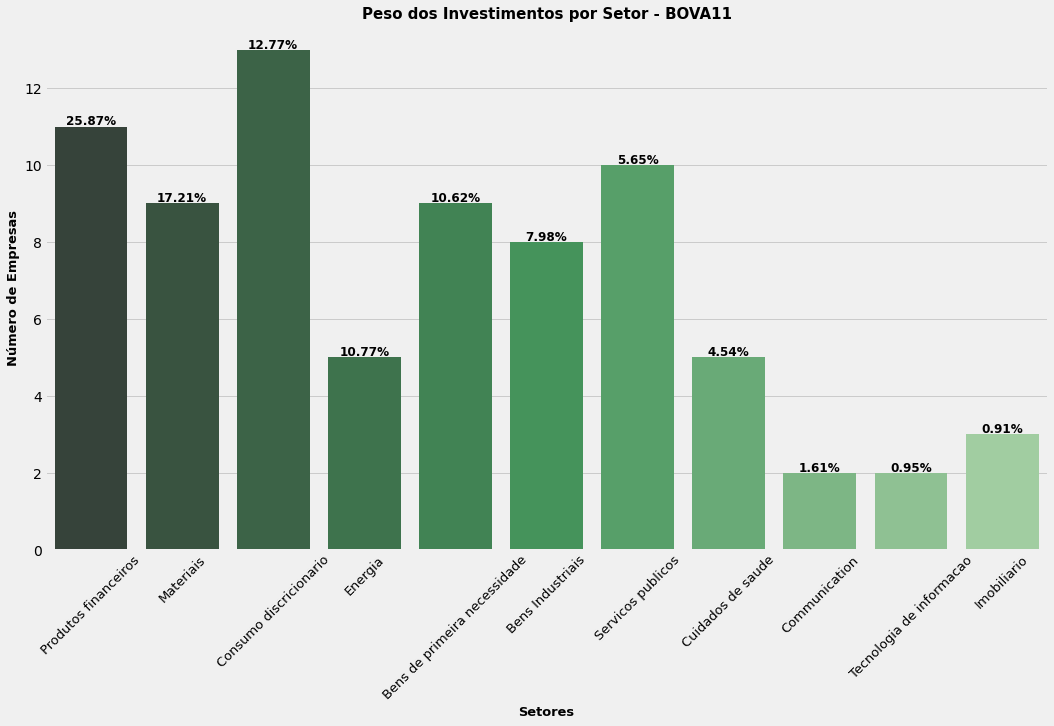

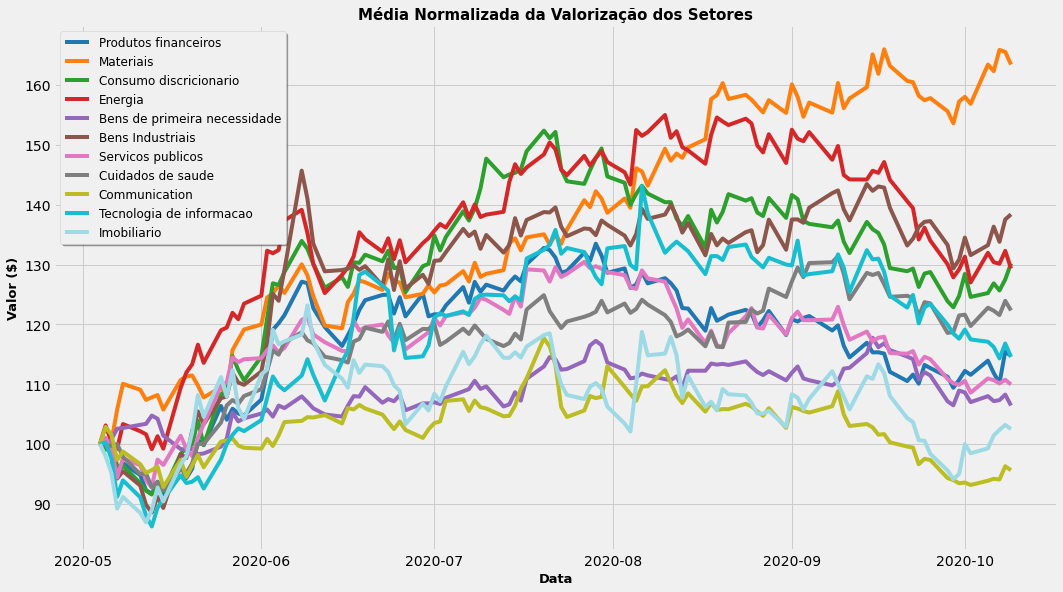

In [8]:
# Juntando dados sobre as acoes nos seus historicos, calculando changes
data = price_hist.merge(bova_stocks.loc[:,['Codigo','Nome','Peso (%)','Setor']], left_on='Stock', right_on='Codigo', how='left').drop('Codigo', axis=1)
data['pct_change_d-1'] = data.groupby('Stock')['close_price'].pct_change(fill_method=None).fillna(0)
data['price_norm'] = 0.0
data = data.sort_values(by=['Stock','Date']).reset_index(drop=True)

actual_stock = ''
for i, row in data.iterrows():
    if row['Stock'] != actual_stock:
        data.at[i, 'price_norm'] = 100
        last_price = 100
        actual_stock = row['Stock']
    else:
        this_value = last_price + last_price * abs(row['pct_change_d-1']) if row['pct_change_d-1'] >= 0 else last_price - last_price * abs(row['pct_change_d-1'])
        data.at[i, 'price_norm'] = this_value
        last_price = this_value
        
display(data.loc[111:,:].head())

# Agrupando por setor
gb_setor = data.groupby(['Date','Setor'], as_index=True).agg(Count = ('Setor','count'), Change = ('pct_change_d-1','mean'), PrecoNormalizado = ('price_norm', 'mean'), Share = ('Peso (%)', 'sum')).rename(columns={'Change' : 'Mean_change_d-1'}).reset_index()
display(gb_setor.head())

# Visao geral dos setores
setor_macroview = gb_setor.loc[:,['Setor','Count','Share']].drop_duplicates().sort_values(by='Share', ascending=False).reset_index(drop=True)
display(setor_macroview.head())

# Plotando distribuicao por setores
plt.figure(figsize=(16,9))
splot = sns.barplot(x='Setor', y='Count', data=setor_macroview, palette='Greens_d')
splot.set_xticklabels(splot.get_xticklabels(), rotation=45, fontsize=13)
i = 0
for p in splot.patches:
    splot.annotate(str(format(setor_macroview['Share'][i], '.2f'))+'%', 
                   (p.get_x() + p.get_width() / 2., p.get_height()-0.1), 
                   ha = 'center', va = 'center', fontweight='bold', fontsize=12,
                   xytext = (0, 9), 
                   textcoords = 'offset points')
    i += 1

splot.set_title('Peso dos Investimentos por Setor - BOVA11', fontweight='bold', fontsize=15)
splot.set_xlabel('Setores', fontsize=13, fontweight='bold')
splot.set_ylabel('Número de Empresas', fontsize=13, fontweight='bold')

# Plotando valorizacao dos setores ao longo do tempo
plt.figure(figsize=(16,9))
setores = setor_macroview['Setor'].unique()
color_qty = len(setores)
cmap = plt.get_cmap('tab20')
cores = [cmap(i) for i in np.linspace(0, 1, color_qty)]
i = 0
for setor in setores:
    plt.plot(pd.to_datetime(gb_setor[gb_setor['Setor'] == setor]['Date']), gb_setor[gb_setor['Setor'] == setor]['PrecoNormalizado'], color=cores[i])
    i += 1

plt.legend(setores, fontsize=12, fancybox=True, frameon=True, shadow=True)
plt.title('Média Normalizada da Valorização dos Setores', fontsize=15, fontweight='bold')
plt.xlabel('Data', fontsize=13, fontweight='bold')
plt.ylabel('Valor ($)', fontsize=13, fontweight='bold')
plt.show()
plt.close()


### Detalhamento por setor:
- Como se comportaram as ações dentro de um mesmo setor?
- Quais setores possuem um comportamento parecido entre suas ações?

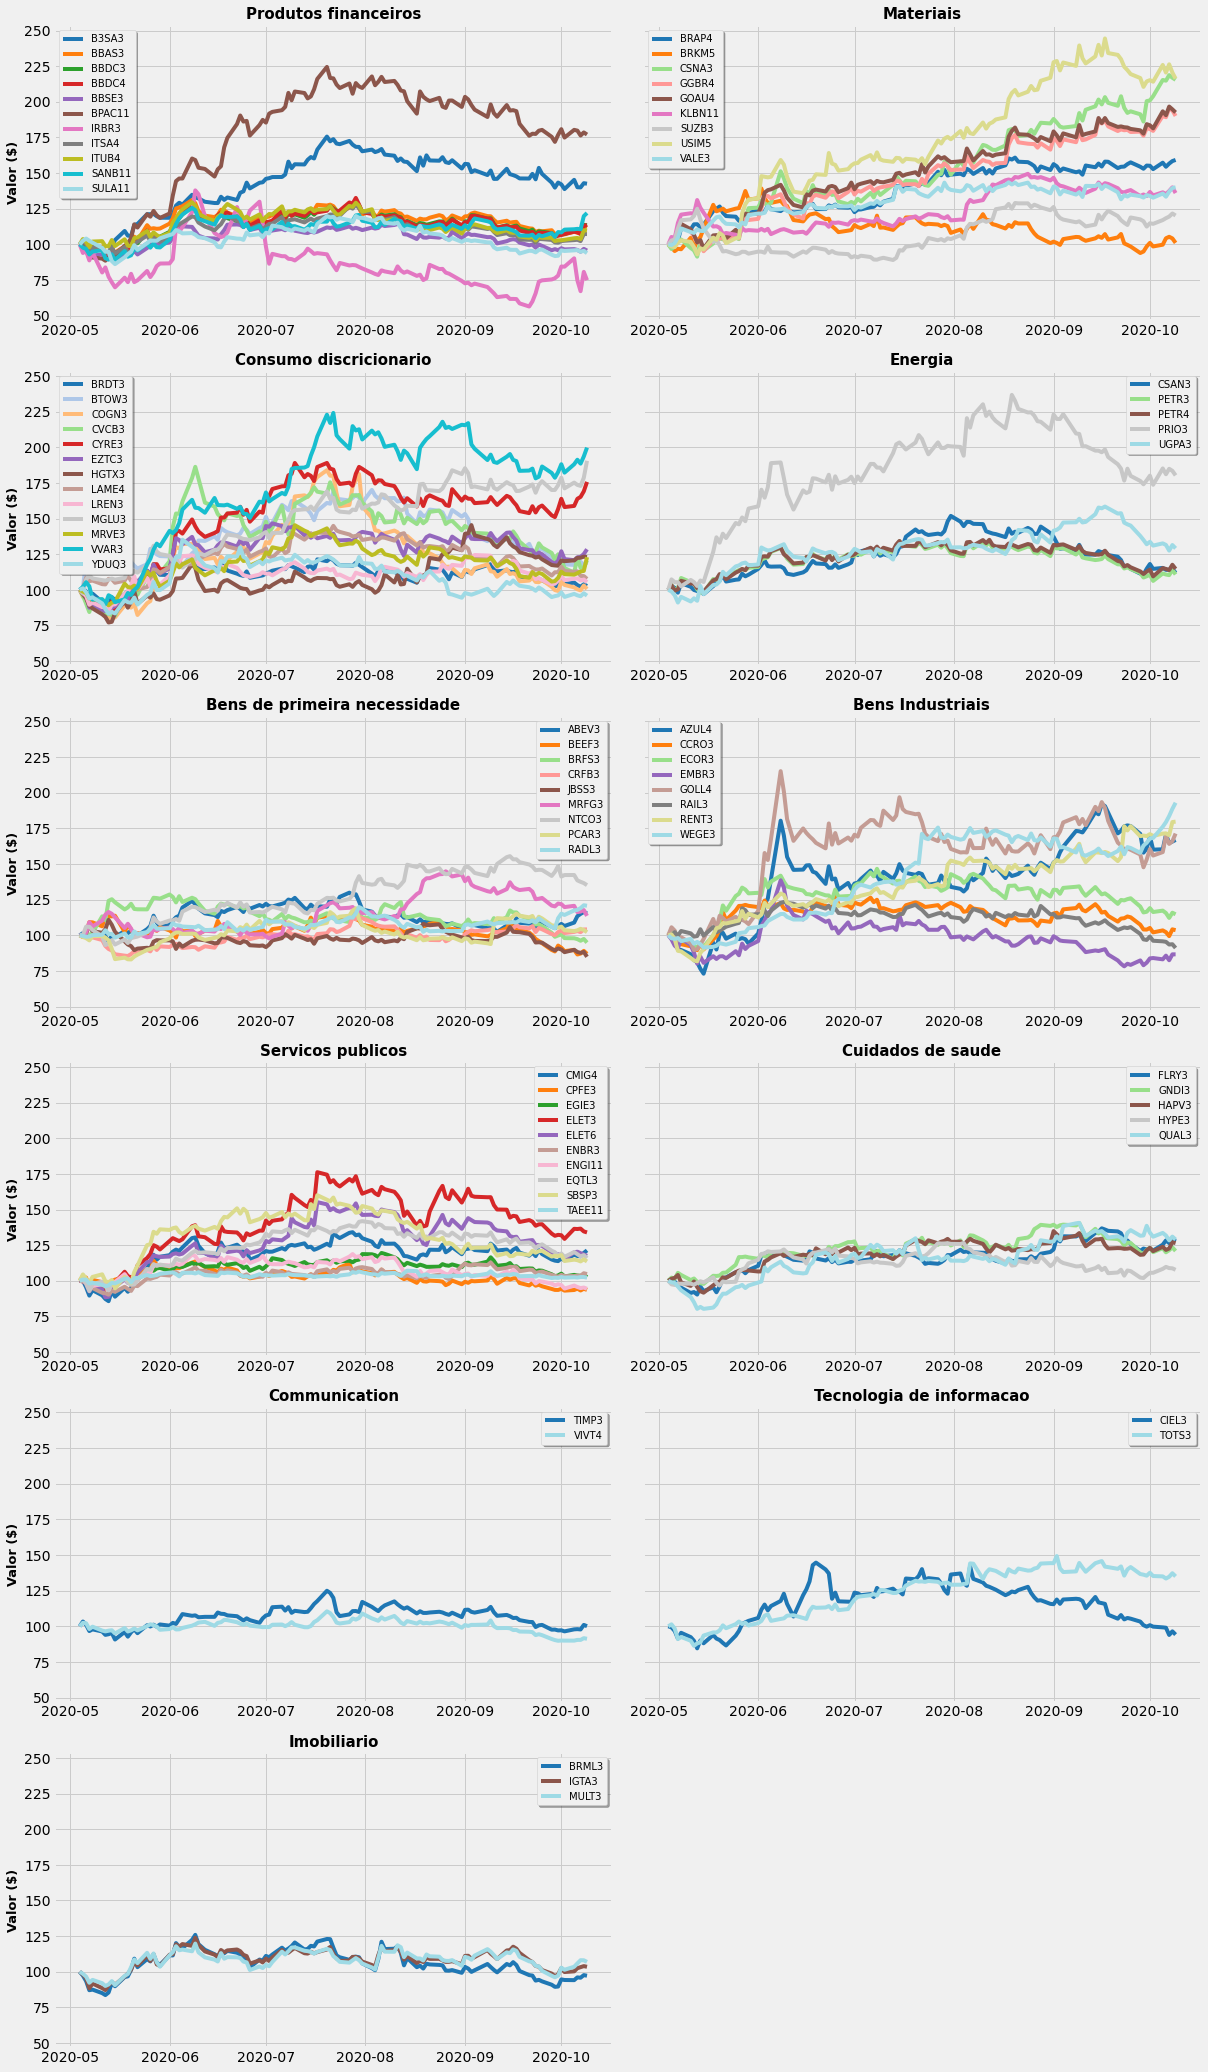

In [9]:
# Detalhamento por setor
fig, axes = plt.subplots(nrows=len(setores)//2 + 1, ncols=2, figsize=(17,29), sharey=True)
ax_row = 0
ax_col = 0
for setor in setores:
    this_ax = axes[ax_row][ax_col]
    ax_row = ax_row if ax_col == 0 else ax_row + 1
    ax_col = 0 if ax_col == 1 else 1
    stocks_list = data[data['Setor'] == setor]['Stock'].unique()
    color_qty = len(stocks_list)
    cmap = plt.get_cmap('tab20')
    cores = [cmap(i) for i in np.linspace(0, 1, color_qty)]
    i = 0
    for stock in stocks_list:
        stock_data = data[(data['Setor'] == setor) & (data['Stock'] == stock)]
        this_ax.plot(pd.to_datetime(stock_data['Date']), stock_data['price_norm'], color=cores[i])
        i += 1
    this_legend = [stock[:-3] for stock in stocks_list]
    this_ax.legend(this_legend, fontsize=10, fancybox=True, frameon=True, shadow=True)
    this_ax.set_title(setor, fontsize=15, fontweight='bold')
    #this_ax.set_xlabel('Data', fontsize=13, fontweight='bold')
    if ax_col == 1:
        this_ax.set_ylabel('Valor ($)', fontsize=13, fontweight='bold')
if len(setores)%2 == 1:
    axes.flat[-1].set_visible(False)
plt.tight_layout()
plt.show()
plt.close()

## Dando atributos para nossos dados

In [10]:
# Adicionando colunas categoricas para a variacao
classes = ["b_lvl6","b_lvl5","b_lvl4","b_lvl3","b_lvl2","b_lvl1","neutral","g_lvl1","g_lvl2","g_lvl3","g_lvl4","g_lvl5","g_lvl6"]
def var_lvl(row):
    neutral = 0.001
    lvl1 = 0.005
    lvl2 = 0.01
    lvl3 = 0.02
    lvl4 = 0.03
    lvl5 = 0.04
    change = row['pct_change_d-1'] if 'pct_change_d-1' in row else row['Mean_change_d-1']
    if change >= 0:
        if change <= neutral:
            this_class = "neutral"
        elif change <= lvl1:
            this_class = "g_lvl1"
        elif change <= lvl2:
            this_class = "g_lvl2"        
        elif change <= lvl3:
            this_class = "g_lvl3"
        elif change <= lvl4:
            this_class = "g_lvl4"
        elif change <= lvl5:
            this_class = "g_lvl5"
        else:
            this_class = "g_lvl6"
    else:
        change = abs(change)
        if change <= neutral:
            this_class = "neutral"
        elif change <= lvl1:
            this_class = "b_lvl1"
        elif change <= lvl2:
            this_class = "b_lvl2"        
        elif change <= lvl3:
            this_class = "b_lvl3"
        elif change <= lvl4:
            this_class = "b_lvl4"
        elif change <= lvl5:
            this_class = "b_lvl5"
        else:
            this_class = "b_lvl6"
    return this_class

# Criando coluna no nivel de Acao e no nivel de Setores
data['var_lvl'] = data.apply(var_lvl, axis=1)
gb_setor['set_var_lvl'] = gb_setor.apply(var_lvl, axis=1)

In [11]:
# Primeiro modelo para prever performance dor setores(um por setor), dado performance do restante dos setores nos ultimos 3 dias
this_setor = 'Bens Industriais'
days = 1
this_df = gb_setor[gb_setor['Setor'] == setor]
this_df = this_df.drop(this_df.columns[1:-1], axis=1).rename(columns={'set_var_lvl': 'output_lvl'}).reset_index(drop=True)
for setor in setores:
    for d in range(1,days+1):
        this_df[setor + ' D-' + str(d)] = ""
    for i,row in this_df.iterrows():
        if i < days:
            continue
        for d in range(1,days+1):
            search_date = this_df.at[i-d,'Date']
            this_df.at[i, setor + ' D-' + str(d)] = gb_setor[(gb_setor['Date'] == search_date) & (gb_setor['Setor'] == setor)]['set_var_lvl'].item()
this_labeled_df = this_df[days:].reset_index(drop=True).drop('Date', axis=1)
display(this_labeled_df)

,output_lvl,Produtos financeiros D-1,Materiais D-1,Consumo discricionario D-1,Energia D-1,Bens de primeira necessidade D-1,Bens Industriais D-1,Servicos publicos D-1,Cuidados de saude D-1,Communication D-1,Tecnologia de informacao D-1,Imobiliario D-1
0,b_lvl4,neutral,neutral,neutral,neutral,neutral,neutral,neutral,neutral,neutral,neutral,neutral
1,b_lvl4,neutral,neutral,b_lvl2,g_lvl5,b_lvl1,g_lvl2,g_lvl3,b_lvl1,g_lvl4,g_lvl1,b_lvl4
2,b_lvl6,b_lvl3,g_lvl1,g_lvl3,b_lvl4,g_lvl3,b_lvl3,b_lvl3,b_lvl1,b_lvl3,b_lvl4,b_lvl4
3,g_lvl4,b_lvl6,g_lvl6,b_lvl6,b_lvl3,g_lvl3,b_lvl6,b_lvl6,g_lvl1,b_lvl6,b_lvl6,b_lvl6
4,b_lvl4,g_lvl4,g_lvl5,g_lvl1,g_lvl6,g_lvl1,g_lvl3,g_lvl5,b_lvl4,g_lvl3,g_lvl5,g_lvl4
...,...,...,...,...,...,...,...,...,...,...,...,...
107,g_lvl2,b_lvl1,b_lvl2,b_lvl4,b_lvl5,b_lvl3,b_lvl4,b_lvl3,b_lvl3,b_lvl1,b_lvl3,b_lvl3
108,g_lvl4,g_lvl4,g_lvl5,g_lvl1,g_lvl5,g_lvl2,g_lvl3,g_lvl4,g_lvl4,g_lvl2,b_lvl1,g_lvl2
109,g_lvl2,b_lvl4,b_lvl1,g_lvl3,b_lvl3,b_lvl2,g_lvl3,b_lvl1,b_lvl1,g_lvl1,b_lvl2,g_lvl4
110,g_lvl2,b_lvl3,g_lvl4,b_lvl2,b_lvl1,g_lvl1,b_lvl4,b_lvl2,b_lvl2,b_lvl1,b_lvl4,g_lvl2


In [12]:
# Translating to Numbers
sub = len(classes)//2
use_columns = ['output_lvl']
for column in this_labeled_df.columns:
    if column.startswith("Bens Industriais"):
        use_columns.append(column)
this_labeled_df = this_labeled_df.loc[:,use_columns]
for idx, classe in enumerate(classes):
    this_labeled_df = this_labeled_df.replace([classe], idx-sub)

display(this_labeled_df)
x_train, x_test, y_train, y_test = train_test_split(this_labeled_df.drop('output_lvl', axis=1, inplace=False), this_labeled_df['output_lvl'],test_size=0.25)
x_train = np.array(x_train).astype(float)
x_test = np.array(x_test).astype(float)
y_train = np.array(y_train).squeeze().astype(float)
y_test = np.array(y_test).squeeze().astype(float)

,output_lvl,Bens Industriais D-1
0,-4,0
1,-4,2
2,-6,-3
3,4,-6
4,-4,3
...,...,...
107,2,-4
108,4,3
109,2,3
110,2,-4


In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
lr = LogisticRegression(max_iter=2000)
lr.fit(x_train, y_train)
lr_predict = lr.predict(x_test)

In [14]:
### print confusion matrix and accuracy score
lr_conf_matrix = confusion_matrix(y_test, lr_predict)
lr_acc_score = accuracy_score(y_test, lr_predict)
print(lr_conf_matrix)
print(lr_acc_score*100)

[[0 0 2 1 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 1 0 0 0 0]
 [0 0 0 3 0 0 0 0 0 0 0]
 [0 0 1 2 0 0 0 0 0 0 0]
 [0 0 0 2 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0]
 [0 0 1 1 0 0 0 0 0 0 0]
 [0 0 1 2 0 0 0 0 0 0 0]
 [0 0 0 2 0 0 0 0 0 0 0]
 [0 0 0 3 0 0 0 0 0 0 0]
 [0 0 0 3 0 0 0 0 0 0 0]]
7.142857142857142


In [15]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
dt.fit(x_train,y_train)
dt_predict = dt.predict(x_test)

In [16]:
#print confusion matrix and accuracy score
dt_conf_matrix = confusion_matrix(y_test, dt_predict)
dt_acc_score = accuracy_score(y_test, dt_predict)
print(dt_conf_matrix)
print(dt_acc_score*100)

[[0 0 0 0 2 0 0 0 0 0 1]
 [0 0 0 0 3 0 0 0 0 0 0]
 [0 0 1 0 0 0 1 0 0 0 1]
 [1 0 0 1 0 0 0 0 0 0 1]
 [1 0 1 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0]
 [0 0 1 0 1 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0 0 1]
 [0 0 1 0 0 0 1 0 0 0 0]
 [1 0 0 1 0 0 1 0 0 0 0]
 [2 0 0 1 0 0 0 0 0 0 0]]
7.142857142857142


In [17]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(x_train,y_train)
nb_predict=nb.predict(x_test)

In [18]:
#print confusion matrix and accuracy score
nb_conf_matrix = confusion_matrix(y_test, nb_predict)
nb_acc_score = accuracy_score(y_test, nb_predict)
print(nb_conf_matrix)
print(nb_acc_score*100)

[[0 0 3 0 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 1 0 0 0 0]
 [0 0 1 1 0 0 1 0 0 0 0]
 [0 0 2 1 0 0 0 0 0 0 0]
 [0 0 0 2 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0]
 [0 0 1 1 0 0 0 0 0 0 0]
 [0 0 1 2 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 1 0 0 0 0]
 [0 0 0 2 0 0 1 0 0 0 0]
 [0 0 0 3 0 0 0 0 0 0 0]]
7.142857142857142


In [19]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(x_train, y_train)
rf_predict=rf.predict(x_test)

In [20]:
#print confusion matrix and accuracy score
rf_conf_matrix = confusion_matrix(y_test, rf_predict)
rf_acc_score = accuracy_score(y_test, rf_predict)
print(rf_conf_matrix)
print(rf_acc_score*100)

[[0 0 0 0 2 0 0 0 0 0 1]
 [0 0 0 0 3 0 0 0 0 0 0]
 [0 0 1 0 0 0 1 0 0 0 1]
 [1 0 0 1 0 0 0 0 0 0 1]
 [1 0 1 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0]
 [0 0 1 0 1 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0 0 1]
 [0 0 1 0 0 0 1 0 0 0 0]
 [1 0 0 1 0 0 1 0 0 0 0]
 [2 0 0 0 0 0 0 1 0 0 0]]
7.142857142857142


In [21]:
from sklearn.svm import SVC

In [22]:
#we shall use the rbf kernel first and check the accuracy
lin_svc = SVC()
lin_svc.fit(x_train, y_train)
lin_svc=rf.predict(x_test)

In [23]:
#print confusion matrix and accuracy score
lin_svc_conf_matrix = confusion_matrix(y_test, rf_predict)
lin_svc_acc_score = accuracy_score(y_test, rf_predict)
print(lin_svc_conf_matrix)
print(lin_svc_acc_score*100)

[[0 0 0 0 2 0 0 0 0 0 1]
 [0 0 0 0 3 0 0 0 0 0 0]
 [0 0 1 0 0 0 1 0 0 0 1]
 [1 0 0 1 0 0 0 0 0 0 1]
 [1 0 1 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0]
 [0 0 1 0 1 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0 0 1]
 [0 0 1 0 0 0 1 0 0 0 0]
 [1 0 0 1 0 0 1 0 0 0 0]
 [2 0 0 0 0 0 0 1 0 0 0]]
7.142857142857142


In [24]:
rbf_svc = SVC(kernel='linear')
rbf_svc.fit(x_train, y_train)
rbf_svc=rf.predict(x_test)

In [25]:
rbf_svc_conf_matrix = confusion_matrix(y_test, rf_predict)
rbf_svc_acc_score = accuracy_score(y_test, rf_predict)
print(rbf_svc_conf_matrix)
print(rbf_svc_acc_score*100)

[[0 0 0 0 2 0 0 0 0 0 1]
 [0 0 0 0 3 0 0 0 0 0 0]
 [0 0 1 0 0 0 1 0 0 0 1]
 [1 0 0 1 0 0 0 0 0 0 1]
 [1 0 1 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0]
 [0 0 1 0 1 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0 0 1]
 [0 0 1 0 0 0 1 0 0 0 0]
 [1 0 0 1 0 0 1 0 0 0 0]
 [2 0 0 0 0 0 0 1 0 0 0]]
7.142857142857142
